In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 69.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, bu

In [1]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH


import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [10]:
dataset[0]

Data(x=[1068, 8], edge_index=[2, 27079], edge_attr=[27079], y=[1068])

In [11]:
dataset[0].y

tensor([-0.4067, -0.1620, -0.4043,  ..., -0.9163, -1.0110, -0.5007])

In [12]:
dataset[0].x

tensor([[-0.4323, -0.4739,  0.2659,  ...,  0.6412,  0.2179, -0.7617],
        [-0.4041, -0.4165, -0.0751,  ...,  0.4464, -0.3916, -0.8137],
        [-0.3892,  0.0634,  0.5913,  ...,  0.2776, -0.0724, -0.8116],
        ...,
        [-0.0232,  0.0580,  0.8699,  ...,  0.6263, -0.2668, -0.9975],
        [-0.9213, -0.3829,  0.7834,  ...,  0.6040,  0.4245, -0.2035],
        [-0.3530, -0.4638,  0.0311,  ...,  0.1012, -0.0982, -0.7666]])

In [13]:
dataset[0].edge_attr

tensor([1., 4., 2.,  ..., 1., 1., 2.])

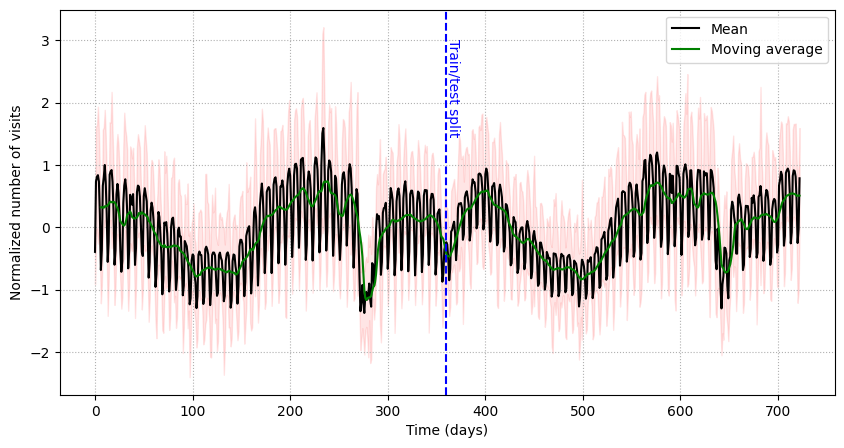

In [14]:

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [15]:
import torch
torch.manual_seed(0)

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|██████████| 50/50 [03:32<00:00,  4.25s/it]


MSE = 0.7926


In [16]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]


In [17]:
y_preds

[-0.3091257,
 -0.30221814,
 -0.44065017,
 -0.02081156,
 -0.15861595,
 0.29403687,
 0.09673945,
 0.13685545,
 -0.14864624,
 -0.476666,
 -0.22276154,
 0.2181776,
 0.34166086,
 0.22538546,
 0.27689767,
 -0.0874569,
 -0.3477538,
 -0.15966885,
 0.16663843,
 0.39093512,
 0.26984984,
 0.25709346,
 0.11882002,
 -0.16203626,
 -0.12522481,
 0.16150445,
 0.4324193,
 0.30866855,
 0.33805087,
 0.13614075,
 -0.42498672,
 -0.15033768,
 0.24641053,
 0.32371065,
 0.33483133,
 0.34941003,
 0.07440922,
 -0.30914718,
 -0.0879561,
 0.21328224,
 0.47879973,
 0.30818632,
 0.3571681,
 0.03719559,
 -0.2540269,
 -0.07328305,
 0.2580595,
 0.42113012,
 0.3501313,
 0.35107383,
 -0.082381904,
 -0.24626072,
 -0.24285425,
 0.18415853,
 0.3730658,
 0.32197556,
 0.31679899,
 -0.022185598,
 -0.51063555,
 -0.19755036,
 0.018592402,
 0.3239085,
 0.3189361,
 0.08615831,
 -0.2469097,
 -0.4346931,
 -0.31939137,
 -0.12701255,
 -0.12745664,
 0.15547217,
 0.059389785,
 -0.14442845,
 -0.44680744,
 -0.52019507,
 -0.29134536,
 0.1

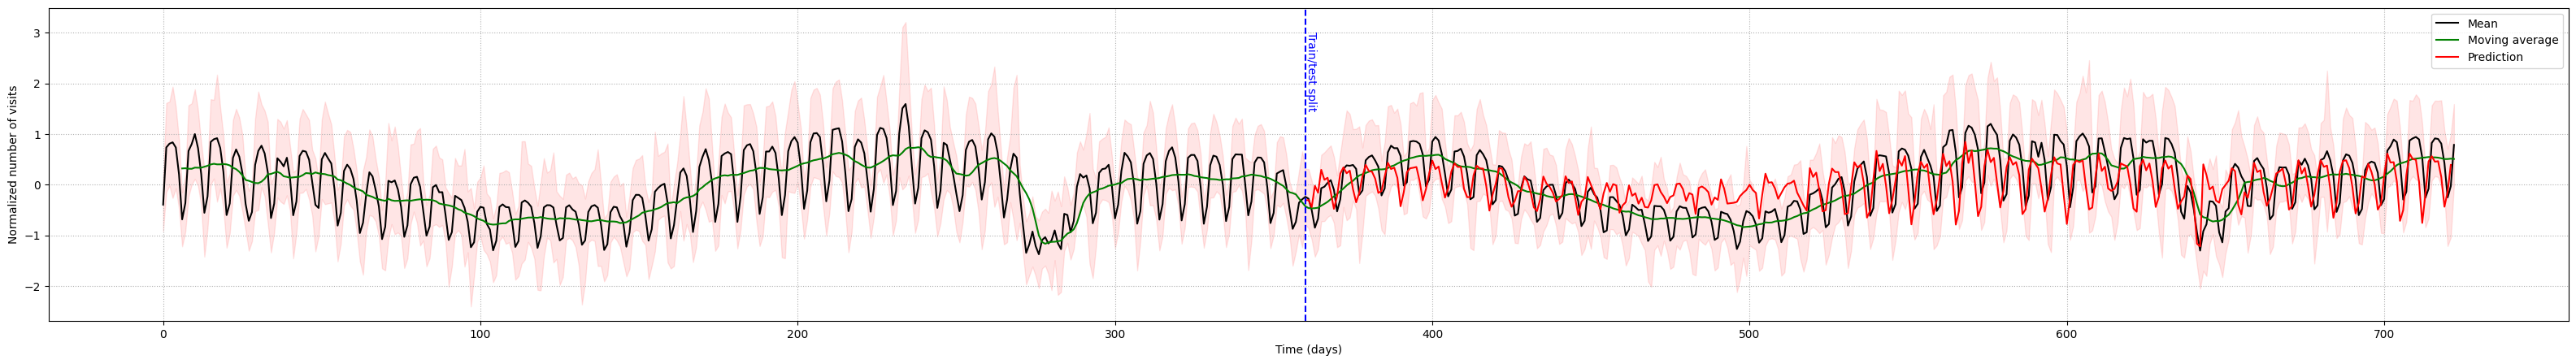

In [22]:

plt.figure(figsize=(40,5), dpi=100)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

<Axes: >

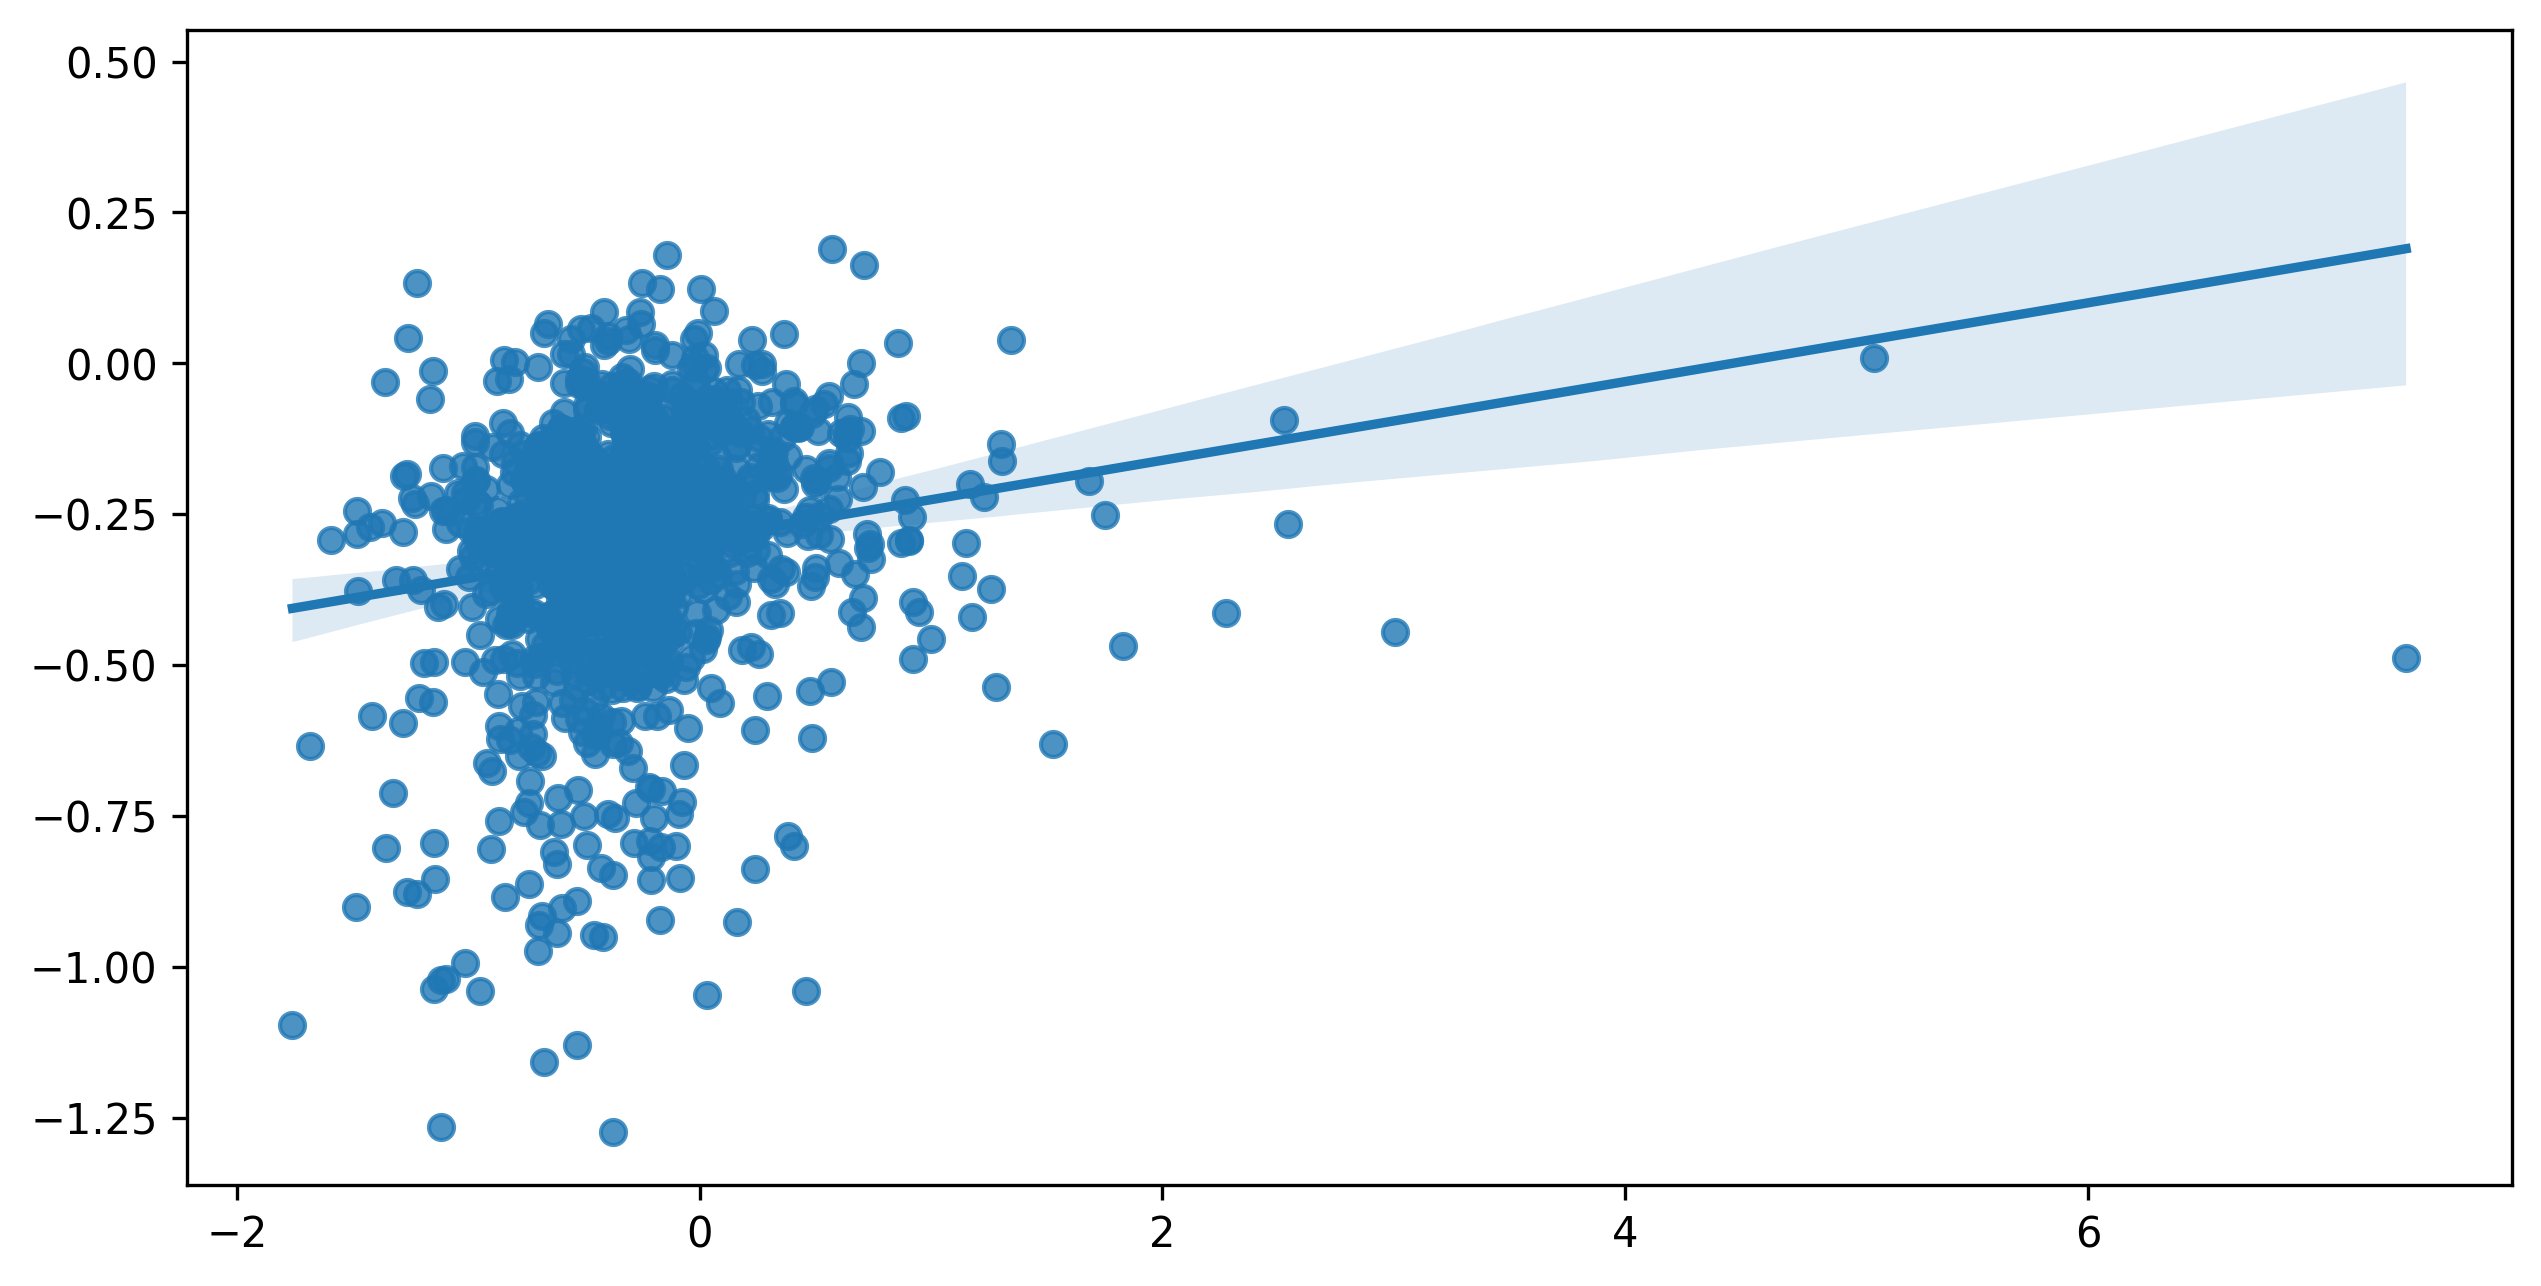

In [19]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)